In [1]:
dataset_path = '/mnt/edisk/dataset/imagenet-mini/val'
qmodel_path = 'quantized.onnx'
model_path = 'origin.onnx'

In [2]:
from tqdm import tqdm
import pickle

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torch.ao.quantization.fake_quantize import FakeQuantize
from torch.ao.quantization.observer import HistogramObserver, PerChannelMinMaxObserver

from onnxutils.common import DatasetUtils
from onnxutils.quantization import symbolic_trace, ModuleQuantizer
from onnxutils.quantization.layer_observer import LayerObserver
from onnxutils.quantization.metric import compute_metrics

from imagenet_pipeline import ImageNetPipeline

# Prepare

In [3]:
class M(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(3)
        self.relu = nn.ReLU()

        self.conv0 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.bn0 = nn.BatchNorm2d(3)
        self.relu0 = nn.ReLU()

        self.conv1 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(3)
        self.relu1 = nn.ReLU()
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu0(x)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        return x

In [4]:
dataset = ImageNetPipeline.get_dataset(dataset_path)
torch_model = M()

torch_model.conv.reset_parameters()
torch_model.bn.reset_parameters()

# Analysis

# Quantization

In [5]:
graph_model = pickle.loads(pickle.dumps(torch_model))
graph_model = symbolic_trace(graph_model)

quantizer = ModuleQuantizer()
graph_model = quantizer.quantize(graph_model, [
    # {
    #     'name': 'x',
    #     'activation': FakeQuantize.with_args(observer=HistogramObserver),
    # },
    # {
    #     'module_name': 'conv',
    #     'weight': FakeQuantize.with_args(observer=PerChannelMinMaxObserver),
    # },
    # {
    #     'module_name': 'relu',
    #     'activation': FakeQuantize.with_args(observer=HistogramObserver),
    # },
])

graph_model.print_readable()

class GraphModule(torch.nn.Module):
    def forward(self, x):
         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())
        conv = self.conv(x);  x = None
        
         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())
        bn = self.bn(conv);  conv = None
        
         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())
        relu = self.relu(bn);  bn = None
        
         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())
        conv0 = self.conv0(relu);  relu = None
        
         # File: /opt/

"class GraphModule(torch.nn.Module):\n    def forward(self, x):\n         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())\n        conv = self.conv(x);  x = None\n        \n         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())\n        bn = self.bn(conv);  conv = None\n        \n         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())\n        relu = self.relu(bn);  bn = None\n        \n         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())\n        conv0 = self.conv0(relu);  relu = None\n        \n       

100%|████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


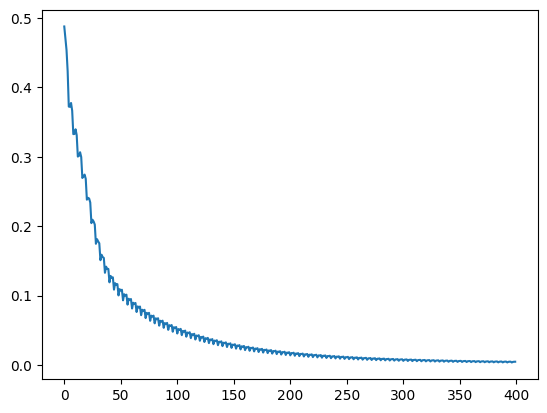

In [6]:
dataloader = DataLoader(
    DatasetUtils.take_front(
        DatasetUtils.transform(
            dataset,
            lambda items: (items[0].to('cuda'),)
        ),
        256
    ),
    batch_size=64
)
torch_model.eval().to('cuda')
graph_model.train().to('cuda')

loss_vals = []
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(graph_model.parameters(), lr=1e-2)

for _ in tqdm(range(100)):
    for data in dataloader:
        gt = torch_model(*data)
        pred = graph_model(*data)
    
        optimizer.zero_grad()
        loss = loss_fn(pred, gt)
        loss.backward()
        optimizer.step()

        loss_vals.append(loss.detach().cpu().item())

plt.plot(loss_vals)

# Preview

In [7]:
dataloader = DataLoader(
    DatasetUtils.drop_front(
        DatasetUtils.transform(
            dataset,
            lambda items: (items[0].to('cuda'),)
        ),
        256
    ),
    batch_size=16
)
torch_model.to('cuda').eval()
graph_model.to('cuda').eval()

for data in dataloader:
    gt = torch_model(*data)
    pred = graph_model(*data)

    print(compute_metrics(gt, pred))
    break

{'cosine': tensor([0.5152, 0.6088, 0.6821, 0.5914, 0.9273, 0.5186, 0.8745, 0.7259, 0.5228,
        0.8480, 0.8874, 0.7760, 0.6396, 0.4520, 0.9227, 0.6538],
       device='cuda:0', grad_fn=<SumBackward1>), 'snr': tensor([1.6781e+09, 5.2657e+08, 3.9687e+08, 1.0623e+09, 3.6086e+07, 7.6783e+08,
        9.0991e+07, 5.2602e+08, 8.0093e+08, 4.7307e+08, 4.3383e+08, 9.4281e+08,
        2.4733e+08, 1.0710e+09, 1.0444e+08, 3.6606e+08], device='cuda:0',
       grad_fn=<SumBackward1>), 'mse': tensor([0.0025, 0.0046, 0.0047, 0.0058, 0.0084, 0.0037, 0.0018, 0.0052, 0.0028,
        0.0042, 0.0045, 0.0017, 0.0041, 0.0019, 0.0026, 0.0017],
       device='cuda:0', grad_fn=<MeanBackward1>)}


# Export

In [8]:
finalized_model = quantizer.finalize(graph_model).to('cuda')
torch.onnx.export(
    finalized_model,
    tuple(next(iter(dataloader))),
    qmodel_path,
    input_names=['x'],
    output_names=['y'],
)
torch.onnx.export(
    torch_model,
    tuple(next(iter(dataloader))),
    model_path,
    input_names=['x'],
    output_names=['y'],
)